# Algorithms for unconstrained nonlinear optimization. First- and second-order methods

In [596]:
import random
import math as m
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import sqrt
from sympy import *
from numpy import array
from numpy.linalg import norm

## Data Generation

In [639]:
eps = 1e-3
accuracy = round(m.log(1/eps, 10))
alpha = random.random()
beta = random.random()
n = 100
x = [k/n for k in range(n + 1)]
y = [alpha * x[k] + beta + random.normalvariate(0, 1) for k in range(n + 1)]

In [640]:
def linear_approx(a, b, x):
    return a * x + b

def linear_approx_derivative_a(a, b, x):
    """Производная по a"""
    return x

def linear_approx_derivative_b(a, b, x):
    """Производная по b"""
    return 1

def grad_linear_approx(a, b, x):
    """Градиент линейной аппроксимации"""
    return Vector(linear_approx_derivative_a(a, b, x), linear_approx_derivative_b(a, b, x))

In [641]:
def rational_approx(a, b, x):
    if 1 + x * b != 0:
        return a / (1 + b * x)
    else:
        return 1000000

def rational_approx_derivative_a(a, b, x):
    "Производная по a"
    if 1 + b * x != 0:
        return 1 / (1 + b * x)
    else:
        return 100000
    
def rational_approx_derivative_b(a, b, x):
    """Производная по b"""
    if 1 + b * x != 0:
        return -a * x / (1 + b * x) ** 2
    else:
        return 100000
    
def grad_rational_approx(a, b, x):
    """Градиент рациональной аппроксимации"""
    return Vector(rational_approx_derivative_a(a, b, x), rational_approx_derivative_b(a, b, x))

In [642]:
approx_grad = {
    rational_approx: grad_rational_approx,
    linear_approx: grad_linear_approx
}

def least_squares(func, a, b):
    d = 0
    for k in range(0, n + 1):
        d += (func(a, b, x[k]) - y[k]) ** 2 
    return d

def grad_least_squares(func, v):
    grad = Vector(0, 0)
    for k in range(0, n + 1):
        res = func(v.a, v.b, x[k]) - y[k]
        grad += 2 * res * approx_grad[func](v.a, v.b, x[k])
    return grad

In [643]:
class Visualise_3d():
    
    def __init__(self, x, y):
        eps = 1e-2
        a = [i * eps for i in range(-len(x), 2 * len(x) + 1)]
        self.a = a
        self.a_np = np.array([a for i in range(len(a))])
        b = [j * eps for j in range(-len(x), 2 * len(y) + 1)]
        self.b = b
        self.b_np = np.array([b for i in range(len(a))])
        self.d_np = []
        self.func = ""

    def build_z(self, func):
        self.func = func
        d = []
        for i in self.a:
            temp_d = []
            for j in self.b:
                temp_d.append(least_squares(func, i, j))
            d.append(temp_d)
        self.d_np = np.array(d)
        
    def draw_chart(self, list_point):
        plt.rcParams.update({
            'figure.figsize': (6, 6),
            'figure.dpi': 200,
            'xtick.labelsize': 4,
            'ytick.labelsize': 4
        })
        ax = plt.figure().add_subplot(111, projection='3d')
        p_x = []
        p_y = []
        p_z = []
        for point in list_point[:-1]:
            point_x = point.a
            p_x.append(point_x)
            point_y = point.b
            p_y.append(point_y)
            point_z = point.value
            p_z.append(point_z)
            ax.scatter(point_x, point_y, point_z, color='red', s=3)
        point_x = list_point[-1].a
        point_y = list_point[-1].b
        point_z = list_point[-1].value
        ax.scatter(point_x, point_y, point_z, color='green', s=6)
#         ax.plot_surface(self.a_np, self.b_np, self.d_np, rstride=5, cstride=5, cmap='viridis', alpha=0.5)
        surf = ax.plot_surface(self.a_np, self.b_np, self.d_np, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        ax.plot(p_x, p_y, p_z, '-ok', linewidth=1)
        ax.view_init(60, 35)
        plt.show()

In [644]:
def visualise_2d(predict_a_b, func):
    dpi = 80
    fig = plt.figure(dpi=dpi, figsize=(1024 / dpi, 512 / dpi))
    plt.scatter(x=x, y=y, c='r', label = "data generated") 
    
    for method in predict_a_b.keys():
        y_k = [func(predict_a_b[method].a, predict_a_b[method].b, i) for i in x]
        plt.plot(x, y_k, label=method)
    
    y_k = [alpha * x[k] + beta for k in range(n + 1)]
    plt.plot(x, y_k, label="init line")
    
    plt.title(func.__name__)
    plt.grid(True)
    plt.legend()
    
    fig.set_figwidth(8)
    fig.set_figheight(8)
    plt.show()

In [645]:
class Vector(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.value = 0
        
    def set_value(self, z):
        self.value = z

    def __repr__(self):
        return "({0}, {1})".format(self.a, self.b)

    def __add__(self, other):
        a = self.a + other.a
        b = self.b + other.b
        return Vector(a, b)

    def __sub__(self, other):
        a = self.a - other.a
        b = self.b - other.b
        return Vector(a, b)

    def __rmul__(self, other):
        a = self.a * other
        b = self.b * other
        return Vector(a, b)
    
    def __mul__(self, other):
        a = self.a * other
        b = self.b * other
        return Vector(a, b)

    def __truediv__(self, other):
        a = self.a / other
        b = self.b / other
        return Vector(a, b)
    
    def sum_vec(self):
        return self.a + self.b

    def c(self):
        return (self.a, self.b)
    
    def to_list(self):
        return [self.a, self.b]

1. Gradient descent
2. (Nonlinear) Conjugate Gradient method
3. Newton’s method
4. Levenberg-Marquardt algorithm

## Gradient descent

In [646]:
approx_grad = {
    rational_approx: grad_rational_approx,
    linear_approx: grad_linear_approx
}

def least_squares_bb(func, v):
    d = 0
    for k in range(0, n + 1):
        d += (func(v[0], v[1], x[k]) - y[k]) ** 2 
    return d

def grad_least_squares_bb(func, v):
    grad = Vector(0, 0)
    for k in range(0, n + 1):
        res = func(v[0], v[1], x[k]) - y[k]
        grad += 2 * res * approx_grad[func](v[0], v[1], x[k])
    return np.array([grad.a, grad.b])

def grad_descent(func, x, niter=100, verbose=False):
    msg = "Maximum number of iterations"
    g_old = grad_least_squares_bb(func, x)
    gamma = 0.9
    for cont in range(niter):
        if verbose:
            print(f"n: {cont}, x: {x}, func: {round(least_squares_bb(func, x),3)}")
        dx = - gamma * g_old
        x = x + dx
        g = grad_least_squares_bb(func, x)
        dg = g - g_old
        g_old = g
        # Barzilai-Borwein method
        gamma = abs(dx.dot(dg)) / dg.dot(dg)
        if norm(g) < eps:
            msg = "Extremum found with desired accuracy"
            break
    print(x, least_squares_bb(func, x), msg)
    vec = Vector(x[0], x[1])
    vec.set_value(least_squares_bb(func, x))
    return vec


vec_grad_descent_linear = grad_descent(linear_approx, [2.0, 2.0])
vec_grad_descent_rational = grad_descent(rational_approx, [2.0, 2.0])

[0.47769034 0.54667806] 135.56616672180675 Extremum found with desired accuracy.
[ 0.50135189 -0.61097417] 134.2756313780809 Extremum found with desired accuracy.


In [648]:
# vis1 = Visualise_3d(x, y)
# vis1.build_z(linear_approx)
# vis2.draw_chart(list_vec_linear)
# vis2 = Visualise_3d(x, y)
# vis2.build_z(rational_approx) 
# vis2.draw_chart(list_vec_rational)

## Non-linear Conjugate Gradient Descent

## Newton’s method

In [343]:
def hessian_linear():
    h11 = 0
    h12 = 0
    h21 = 0
    h22 = 0
    for k in range(0, n + 1):
        h11 += 2 * x[k] ** 2
        h12 += 2 * x[k]
        h21 += 2 * x[k]
        h22 += 2
    return h11, h12, h21, h22   

def hessian_rational(vec):
    h11 = 0
    h12 = 0
    h21 = 0
    h22 = 0
    for k in range(0, n + 1):
        h11 += 2 / ((1 + vec.b * x[k]) ** 2)
        h12 += - 4 * vec.a * x[k] / ((1 + vec.b * x[k]) ** 3) + 2 * x[k] * y[k] / ((1 + vec.b * x[k]) ** 2)
        h21 += - 4 * vec.a * x[k] / ((1 + vec.b * x[k]) ** 3) + 2 * x[k] * y[k] / ((1 + vec.b * x[k]) ** 2)
        h22 += 6 * vec.a ** 2 * x[k] ** 2 / ((1 + vec.b * x[k]) ** 4) - 4 * vec.a * x[k] ** 2 * y[k] / ((1 + vec.b * x[k]) ** 2)
    return h11, h12, h21, h22  

In [388]:
hessian = {
    "linear": hessian_linear(),
    "rational": hessian_rational(list_vec_rational[-1]), 
}
hessian

{'linear': (67.67, 101.0, 101.0, 202),
 'rational': (78.9150982039800,
  -9.13423201059114,
  -9.13423201059114,
  -3.13748385953262)}

## Levenberg-Marquardt algorithm

## Visualise

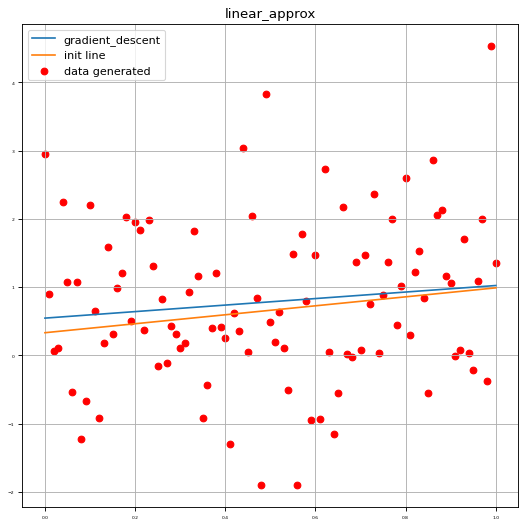

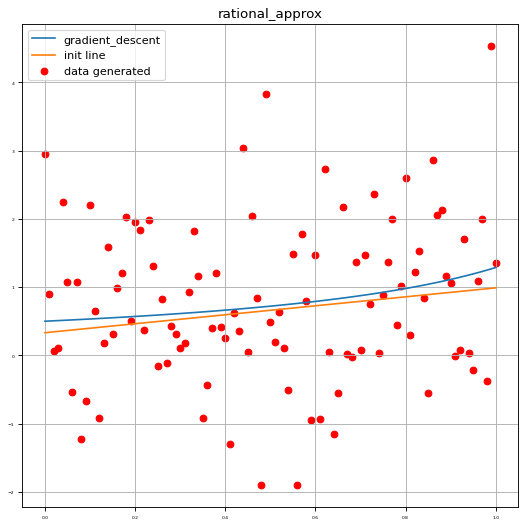

In [649]:
linear_predict_a_b = {
    "gradient_descent": vec_grad_descent_linear
}
rational_predict_a_b = {
    "gradient_descent": vec_grad_descent_rational
}
visualise_2d(linear_predict_a_b, linear_approx)
visualise_2d(rational_predict_a_b, rational_approx)